# Kaggle에 있는 brain-tumor 데이터셋 기반 U-Net Segmentation 공부코드 입니다.

In [1]:
import random
import math
import time
import pandas as pd
import numpy as np

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

# Setup seeds
torch.manual_seed(1237)
np.random.seed(1237)
random.seed(1237)

import os
import glob
import random
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import make_grid
import torchvision.transforms as tt
import albumentations as A
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchvision import transforms as T

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

from torchsummary import summary

In [2]:
ROOT_PATH = "C:/Users/ok/Desktop/archive/lgg-mri-segmentation/kaggle_3m/"

mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
print("mask files: ", len(mask_files))

image_files = [file.replace('_mask', '') for file in mask_files]
print("image files: ", len(image_files))

def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

files_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

mask files:  3929
image files:  3929


In [3]:
class BrainTumorDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.df = df
        self.transforms = transform
    
    def __len__(self):
        return len(self.df['image_path'].values.tolist())
        
    def __getitem__(self, index):
        image_ = self.df['image_path']
        image_ = image_.values
        image_ = image_.tolist()
        image_ = image_[index]
        image_ = Image.open(image_)
        img_arr = np.array(image_)
        
        
        mask_ = self.df['mask_path']
        mask_ = mask_.values
        mask_ = mask_.tolist()
        mask_ = mask_[index]
        mask_ = Image.open(mask_)
        mask_ = np.array(mask_)
        
        mask_ = mask_ / 255.0
        
        msk_ = torch.Tensor(mask_).long()
        
        if self.transforms is not None:
            img_ = self.transforms(img_arr)
        
        return img_, msk_

In [4]:
t1 = tt.Compose([tt.ToTensor(),
                tt.Normalize(mean = (0.485, 0.56, 0.406), std = (0.229, 0.224, 0.225))
        ])

In [5]:
dataset_ = BrainTumorDataset(files_df, transform=t1)

In [6]:
train_loader = DataLoader(dataset_, batch_size=4, shuffle=True)

In [7]:
val_loader = DataLoader(dataset_, batch_size=4, shuffle=True)

In [8]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [9]:
num_classes = 2

In [10]:
epochs = 10
lr = 0.01

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print("Type of device: ", device)

Type of device:  cuda


In [12]:
model = UNet(num_classes = num_classes).to(device)

In [18]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [19]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [20]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [22]:
max_lr = 1e-3
epoch = 20
weight_decay = 1e-4

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

In [26]:
torch.cuda.empty_cache()
train_losses = []
test_losses = []
val_iou = []; val_acc = []
train_iou = []; train_acc = []
lrs = []
min_loss = np.inf
decrease = 1 ; not_improve=0

model.to(device)
fit_time = time.time()

for e in range(epochs):
    since = time.time()
    running_loss = 0
    iou_score = 0
    accuracy = 0
    
    #training loop
    model.train()
    for i, data in enumerate(tqdm(train_loader)):
        #training phase
        image_tiles, mask_tiles = data
        
        image = image_tiles.to(device); mask = mask_tiles.to(device);
        #forward
        output = model(image)
        loss = criterion(output, mask)
        #evaluation metrics
        iou_score += mIoU(output, mask)
        accuracy += pixel_accuracy(output, mask)
        #backward
        loss.backward()
        optimizer.step() #update weight          
        optimizer.zero_grad() #reset gradient

        #step the learning rate
        lrs.append(get_lr(optimizer))
        scheduler.step() 

        running_loss += loss.item()
    
    else:
        model.eval()
        test_loss = 0
        test_accuracy = 0
        val_iou_score = 0
        
        #validation loop
        with torch.no_grad():
            for i, data in enumerate(tqdm(val_loader)):
                #reshape to 9 patches from single image, delete batch size
                image_tiles, mask_tiles = data

                image = image_tiles.to(device); mask = mask_tiles.to(device);
                output = model(image)
                #evaluation metrics
                val_iou_score +=  mIoU(output, mask)
                test_accuracy += pixel_accuracy(output, mask)
                #loss
                loss = criterion(output, mask)                                  
                test_loss += loss.item()

        #calculatio mean for each batch
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(val_loader))
        
        if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

        if (test_loss/len(val_loader)) > min_loss:
            not_improve += 1
            min_loss = (test_loss/len(val_loader))
            print(f'Loss Not Decrease for {not_improve} time')
            if not_improve == 7:
                print('Loss not decrease for 7 times, Stop Training')
                break
        
        #iou
        val_iou.append(val_iou_score/len(val_loader))
        train_iou.append(iou_score/len(train_loader))
        train_acc.append(accuracy/len(train_loader))
        val_acc.append(test_accuracy/ len(val_loader))
        print("Epoch:{}/{}..".format(e+1, epochs),
              "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
              "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
              "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
              "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
              "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
              "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
              "Time: {:.2f}m".format((time.time()-since)/60))


  0%|          | 0/983 [00:00<?, ?it/s]

  0%|          | 0/983 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.087 
Epoch:1/10.. Train Loss: 0.318.. Val Loss: 0.087.. Train mIoU:0.680.. Val mIoU: 0.720.. Train Acc:0.961.. Val Acc:0.992.. Time: 2.03m


  0%|          | 0/983 [00:00<?, ?it/s]

  0%|          | 0/983 [00:00<?, ?it/s]

Loss Decreasing.. 0.087 >> 0.023 
Epoch:2/10.. Train Loss: 0.033.. Val Loss: 0.023.. Train mIoU:0.738.. Val mIoU: 0.790.. Train Acc:0.993.. Val Acc:0.994.. Time: 2.04m


  0%|          | 0/983 [00:00<?, ?it/s]

  0%|          | 0/983 [00:00<?, ?it/s]

Loss Decreasing.. 0.023 >> 0.022 
Epoch:3/10.. Train Loss: 0.021.. Val Loss: 0.022.. Train mIoU:0.758.. Val mIoU: 0.730.. Train Acc:0.994.. Val Acc:0.994.. Time: 2.05m


  0%|          | 0/983 [00:00<?, ?it/s]

  0%|          | 0/983 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:4/10.. Train Loss: 0.019.. Val Loss: 0.038.. Train mIoU:0.768.. Val mIoU: 0.723.. Train Acc:0.994.. Val Acc:0.987.. Time: 2.02m


  0%|          | 0/983 [00:00<?, ?it/s]

  0%|          | 0/983 [00:00<?, ?it/s]

Loss Decreasing.. 0.038 >> 0.014 
saving model...
Epoch:5/10.. Train Loss: 0.019.. Val Loss: 0.014.. Train mIoU:0.769.. Val mIoU: 0.783.. Train Acc:0.994.. Val Acc:0.995.. Time: 2.04m


  0%|          | 0/983 [00:00<?, ?it/s]

  0%|          | 0/983 [00:00<?, ?it/s]

Loss Decreasing.. 0.014 >> 0.014 
Epoch:6/10.. Train Loss: 0.017.. Val Loss: 0.014.. Train mIoU:0.783.. Val mIoU: 0.793.. Train Acc:0.994.. Val Acc:0.995.. Time: 2.05m


  0%|          | 0/983 [00:00<?, ?it/s]

  0%|          | 0/983 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:7/10.. Train Loss: 0.016.. Val Loss: 0.015.. Train mIoU:0.787.. Val mIoU: 0.775.. Train Acc:0.995.. Val Acc:0.995.. Time: 2.04m


  0%|          | 0/983 [00:00<?, ?it/s]

  0%|          | 0/983 [00:00<?, ?it/s]

Loss Decreasing.. 0.015 >> 0.013 
Epoch:8/10.. Train Loss: 0.014.. Val Loss: 0.013.. Train mIoU:0.803.. Val mIoU: 0.796.. Train Acc:0.995.. Val Acc:0.996.. Time: 2.03m


  0%|          | 0/983 [00:00<?, ?it/s]

  0%|          | 0/983 [00:00<?, ?it/s]

Loss Decreasing.. 0.013 >> 0.012 
Epoch:9/10.. Train Loss: 0.013.. Val Loss: 0.012.. Train mIoU:0.811.. Val mIoU: 0.797.. Train Acc:0.995.. Val Acc:0.996.. Time: 2.05m


  0%|          | 0/983 [00:00<?, ?it/s]

  0%|          | 0/983 [00:00<?, ?it/s]

Loss Decreasing.. 0.012 >> 0.010 
Epoch:10/10.. Train Loss: 0.011.. Val Loss: 0.010.. Train mIoU:0.827.. Val mIoU: 0.825.. Train Acc:0.996.. Val Acc:0.996.. Time: 2.05m
Total time: 20.42 m


SyntaxError: 'return' outside function (1983146152.py, line 108)

In [28]:
history = {'train_loss' : train_losses, 'val_loss': test_losses,
           'train_miou' :train_iou, 'val_miou':val_iou,
           'train_acc' :train_acc, 'val_acc':val_acc,
           'lrs': lrs}

print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))

Total time: 22.46 m


In [29]:
torch.save(model, 'Unet-Mobilenet.pt')

In [30]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

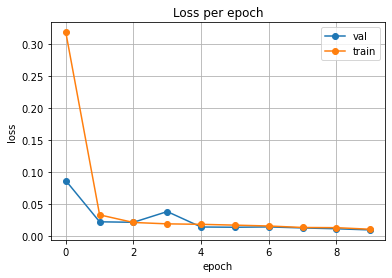

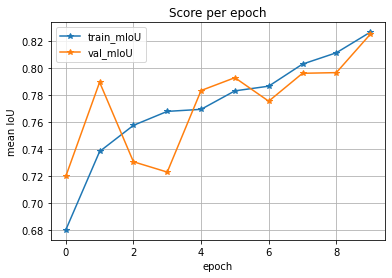

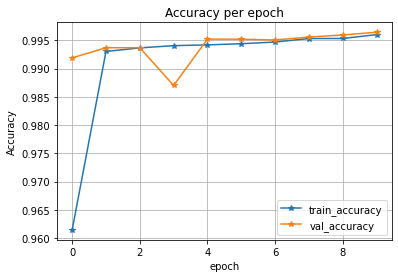

In [31]:
plot_loss(history)
plot_score(history)
plot_acc(history)